<a href="https://colab.research.google.com/github/elambrop/Machine-Learned/blob/main/Various%20datasets/20210123_DCGAN_cDCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Face generation with DCGANs**

---

In this notebook we explore Generative Adversarial Networks for the task of producing new images, specifically generating faces based on the [UTKFace](https://susanqq.github.io/UTKFace/) dataset.

### GANs

[Generative Adversarial Networks](https://en.wikipedia.org/wiki/Generative_adversarial_network) (GANs) are a form of unsupervised learning algorithm for producing new content. Two networks are trained by competing with each other: A generator network tries to produce realistic data, while a classifier network (called the critic or discriminator) tries to disinguish which data came from the original dataset and which has been artificially generated. The generator produces progressively more realistic samples, while the discriminator gets better at finding the fake samples.

Let's start with some imports

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os 
import pathlib
import random

In [ ]:
from IPython import display
from tqdm import tqdm

In [ ]:
#mounting Google Drive to use the data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tarfile

tar = tarfile.open('/content/drive/MyDrive/UTK/UTKFace.tar.gz', "r:gz")
tar.extractall()
tar.close()

## UTKFace

The dataset consists of 23708 color images of faces from various ages and races. The faces are cropped and alligned which helps with the generation process since we don't want background features to be included in the generated images.

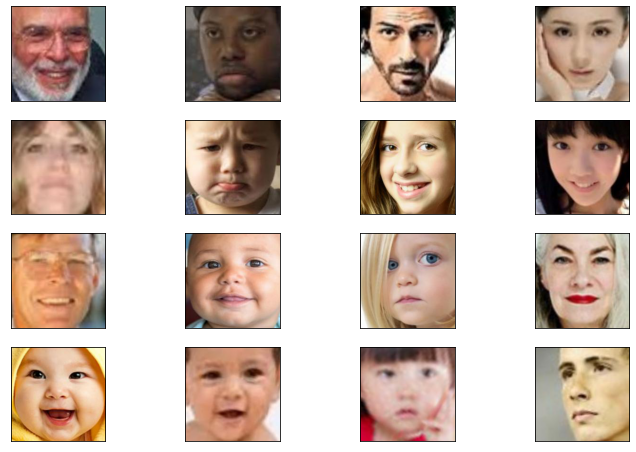

In [ ]:
def img(path):
  img = tf.keras.preprocessing.image.load_img(path)
  img = tf.keras.preprocessing.image.img_to_array(img)
  img = tf.cast(img, tf.float32)
  img = img/255.0
  return img

plt.figure(figsize=(12,8))
j=1
for _ in range(4):
  for _ in range(4):
    image = img('/content/UTKFace/'+os.listdir('/content/UTKFace/')[random.randint(0,23708)])
    ax = plt.subplot(4, 4, j)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(image)
    j+=1

## Network architecture

The architecture we'll use in this notebook uses deep convolutional networks ([DCGAN](https://arxiv.org/abs/1511.06434)) and is one of the most popular for adversarial neworks.

The generator takes as input a vector of random numbers and using transpose convolutions upsamples the vector into an image of desired size.

The critic is a deep convolutιonal networks that performs classification on fake and real images.

Over the years, best practices for training GANs have been established through experimentation. These include the use of batch normalization, the use of certain activation functions etc. A great summary of these practices can be found [here](https://github.com/soumith/ganhacks).

## Generator

First we construct the block that is going to be the basis of the generator network. I uses Conv2Dtranspose layers for upsampling, Batch Normalization and Leaky ReLU as activation function, except for the last layer which will use a Tanh activation function.

In [ ]:
class GeneratorBlock(tf.keras.Model):
  def __init__(self, filters, kernel, strides, final=False):
    super(GeneratorBlock,self).__init__()

    self.filters = filters
    self.kernel = kernel
    self.strides = strides
    self.initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    self.final = final
    self.conv_transpose = tf.keras.layers.Conv2DTranspose(self.filters, self.kernel, self.strides, 
                                                          padding='same', use_bias=False, kernel_initializer=self.initializer)
    self.batch_norm = tf.keras.layers.BatchNormalization()
    self.act1 = tf.keras.layers.LeakyReLU(0.2)
    self.act2 = tf.keras.layers.Activation('tanh')

  def call(self, inputs):
    conv_transpose = self.conv_transpose(inputs)
    if not self.final:
      batch_norm = self.batch_norm(conv_transpose)
      lrelu = self.act1(batch_norm)
      return lrelu

    else:
      tanh = self.act2(conv_transpose)
      return tanh

In [ ]:
#we choose the dimension of the noise vector to be 128 but it can be any value

noise_dim = 128

def generator_3():
  gen_input = tf.keras.Input(shape=(noise_dim,))
  reshape = tf.keras.layers.Reshape((1,1,noise_dim))(gen_input)
  gen_0 = GeneratorBlock(128,10,5)(reshape)
  gen1 = GeneratorBlock(64,4,2)(gen_0)
  gen2 = GeneratorBlock(32,4,2)(gen1)
  gen3 = GeneratorBlock(16,4,2)(gen2)
  gen4 = GeneratorBlock(3,4,2,final=True)(gen3)


  gen_model = tf.keras.Model(inputs=gen_input,outputs=gen4)

  return gen_model

gen_3 = generator_3()

gen_3.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 1, 1, 128)         0         
_________________________________________________________________
generator_block_20 (Generato (None, 5, 5, 128)         1638912   
_________________________________________________________________
generator_block_21 (Generato (None, 10, 10, 64)        131328    
_________________________________________________________________
generator_block_22 (Generato (None, 20, 20, 32)        32896     
_________________________________________________________________
generator_block_23 (Generato (None, 40, 40, 16)        8256      
_________________________________________________________________
generator_block_24 (Generato (None, 80, 80, 3)         768

## Critic

A mentioned previously, the discriminator is convolutional network that classifies the images into fake and real. Instead of a Dense layer it uses a Conv2D layer with sigmoid activation function to classify the images.

In [ ]:
class CriticBlock(tf.keras.Model):
  def __init__(self, filters, kernel, strides):
    super(CriticBlock,self).__init__()

    self.filters = filters
    self.kernel = kernel
    self.strides = strides
    self.initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    self.conv = tf.keras.layers.Conv2D(self.filters, self.kernel, self.strides, 
                                       padding='same', kernel_initializer=self.initializer)
    self.batch_norm = tf.keras.layers.BatchNormalization()
    self.act = tf.keras.layers.LeakyReLU(alpha=0.2)

  def call(self, inputs):
    conv = self.conv(inputs)
    batch_norm = self.batch_norm(conv)
    lrelu = self.act(conv)
    return lrelu

In [ ]:
def critic_3():
  crit_input = tf.keras.Input(shape=(80,80,3))
  crit1 = CriticBlock(16,4,2)(crit_input)
  crit2 = CriticBlock(32,4,2)(crit1)
  crit3 = CriticBlock(64,4,2)(crit2)
  crit4 = CriticBlock(128,4,2)(crit3)
  crit5 = CriticBlock(256,5,5)(crit4)
  conv = tf.keras.layers.Conv2D(1, activation='sigmoid', padding='same', kernel_size=(4,4), 
                                kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02))(crit5)

  crit_model = tf.keras.Model(inputs=crit_input,outputs=conv)

  return crit_model

crit_3 = critic_3()

crit_3.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 80, 80, 3)]       0         
_________________________________________________________________
critic_block_31 (CriticBlock (None, 40, 40, 16)        848       
_________________________________________________________________
critic_block_32 (CriticBlock (None, 20, 20, 32)        8352      
_________________________________________________________________
critic_block_33 (CriticBlock (None, 10, 10, 64)        33088     
_________________________________________________________________
critic_block_34 (CriticBlock (None, 5, 5, 128)         131712    
_________________________________________________________________
critic_block_35 (CriticBlock (None, 1, 1, 256)         820480    
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 1, 1, 1)           409

Both networks use a nromal distribution to initialize their weights.

## Loss and optimizer

Since we have two networks we need an optimizer and a loss function for each one. The Adam optimizer is chosen for both networks with hyperparameters chosen based on the original DCGAN paper.


In [ ]:
crit_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

loss_func = tf.keras.losses.BinaryCrossentropy(from_logits=True)

The binary cross-entropy is chosen as loss function, however a different calculation is done to find the generator and critic losses.

For the generator, the loss is given by calculating the binary cross-entropy given the critic's predictions on batches of generated images (the `fake_preds` argument). Since we want the generator to output progressively better images, the other argument in the loss function is a tensor of ones that represent the labels of real images. Therefore gradient descent will push the generator to the direction where the critic's predictions on fake images are close to one. 

In [ ]:
def gen_loss(fake_preds):
  return loss_func(tf.ones_like(fake_preds), fake_preds)

The critic's loss is given by taking its predictions on fake and real images, calculating the binary cross-entropy for each and taking their sum.

In [ ]:
def crit_loss(real_preds, fake_preds):
  real_loss = loss_func(noise_labels(tf.ones_like(real_preds)), real_preds)
  fake_loss = loss_func(noise_labels(tf.zeros_like(fake_preds)), fake_preds)
  total = real_loss + fake_loss
  return total

A trick that is used to enhance performance is adding random noise to the labels. This has the effect of making the critic's predictions less certain.

In [ ]:
def noise_labels(labels):
  labels = tf.cast(labels, tf.float32)
  return labels + 0.05 * tf.random.uniform(labels.shape)

## Training loop

The training loop consists of the following steps for each epoch:



*   a noise vector is fed to the generator to produce fake images
*   the critic gives its predictions on the real and fake images
*   the loss is calculated for the generator and critic
*   the gradients are calculated for the generator and critic loss
*   the gradients are applied to the weights of each model







In [ ]:
BATCH_SIZE = 100

@tf.function
def new_train_step(images):

  noise = tf.random.normal(shape=(BATCH_SIZE, noise_dim))

  with tf.GradientTape() as gen_tape, tf.GradientTape() as crit_tape:
    fake_images = gen_3(noise, training=True)

    real_preds = crit_3(images, training=True)
    fake_preds = crit_3(fake_images, training=True)

    g_loss = gen_loss(fake_preds)
    c_loss = crit_loss(real_preds, fake_preds)

  gen_grads = gen_tape.gradient(g_loss, gen_3.trainable_variables)
  crit_grads = crit_tape.gradient(c_loss, crit_3.trainable_variables)

  gen_optimizer.apply_gradients(zip(gen_grads, gen_3.trainable_variables))
  crit_optimizer.apply_gradients(zip(crit_grads, crit_3.trainable_variables))
  return c_loss, g_loss

We are ready to train our GAN! We only need to do some preprocessing on the data.

For this we create a `tf.data.Dataset` object. The images are resized to 80 by 80 pixels (from 200 by 200 originally) and the pixels are rescaled to (-1,1).

In [ ]:
data_dir = '/content/UTKFace'

data_dir = pathlib.Path(data_dir)

list_ds = tf.data.Dataset.list_files(str(data_dir/'*'))

def decode_img(img):
  img = tf.image.decode_jpeg(img, channels=3)
  return tf.image.resize(img, [80, 80])

def process_path(file_path):
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img

In [ ]:
ds = list_ds.map(process_path).map(lambda x: (x - 127.5) / 127.5).take(23700).shuffle(23700).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

We also create a seed vector in order to visualize the progress of the generated images during training.

In [ ]:
seed = tf.random.normal([16, noise_dim])

We wil train the netowrks for 50 epochs with updates on the loss every 50 steps.

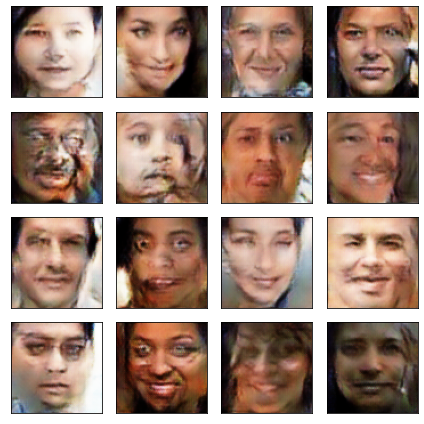


100%|██████████| 50/50 [17:06<00:00, 20.52s/it]


In [ ]:
EPOCHS = 50


critic_loss_2 = []
generator_loss_2 = []
for epoch in tqdm(range(EPOCHS)):
  print('\nEpoch', epoch)

  for step, images in enumerate(ds):
    c_loss, g_loss = new_train_step(images)
    if step % 100 == 0:
      print('critic loss at step {}: {}'.format(step, c_loss))
      print('generator loss at step {}: {}'.format(step, g_loss))
      critic_loss_2.append(tf.squeeze(c_loss))
      generator_loss_2.append(tf.squeeze(g_loss))

  display.clear_output(wait=True)

  plt.figure(figsize=(6,6))
  predictions = gen_3(seed, training=False)
  for i in range(predictions.shape[0]):
    ax = plt.subplot(4, 4, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(tf.cast((predictions[i,:, :, :] * 127.0) + 127.5, tf.uint32))
    plt.tight_layout()
      
  
  plt.savefig('/content/drive/MyDrive/mnist_pngs/wloss_rgb_face_img_{epoch}'.format(epoch=epoch))
  plt.show()


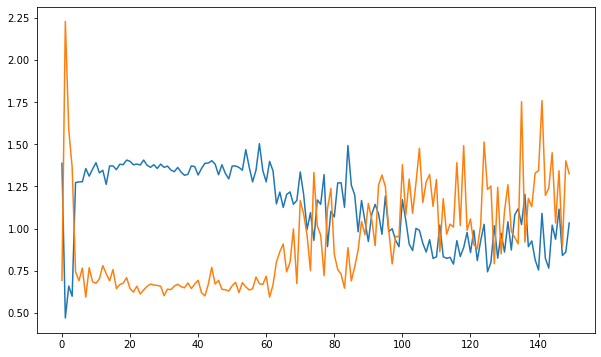

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(critic_loss_2)
plt.plot(generator_loss_2)

We see that the generator loss has greater flactuations than the critic and starts to oscillate around the value 1. The critic shows a downward trend. Both networks look like they begin to converge to some value and would probably benefit from more training time.

Let's show some of the generated images:

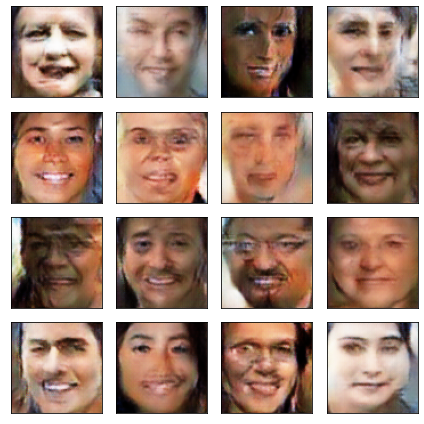

In [ ]:
example = tf.random.normal(shape=(16,128))

plt.figure(figsize=(6,6))
predictions = gen_3(example, training=False)
for i in range(predictions.shape[0]):
  ax = plt.subplot(4, 4, i+1)
  ax.set_xticks([])
  ax.set_yticks([])
  plt.imshow(tf.cast((predictions[i,:, :, :] * 127.0) + 127.5, tf.uint32))
  plt.tight_layout()

In general the faces generated are not very realistic, in fact some are barely recognizable as faces. However given the small size of the models and the relatively short training time the results are quite good. For reference the generator in the original DCGAN paper has the same number of hidden layers as our generator, but 8 times more units per layer and produced smaller images (64 by 64).

# Conditional GANs
The DCGAN gave us decent results however there is no control over what kind of images are generated: the generator will just output images based on the random noise vector it is given.

With a few tweaks in the code we can incorporate information from the labels into hour networks and create what's called a Conditional GAN.

### Getting the labels

The labels for each image are actually encoded in the file name. For instance, an image with the name ``` 18_1_0_20170109212921724.jpg.chip.jpg ``` denotes a person of 18 years old, female (denoted with 1) and white (denoted with zero). We will extract these numbers from the title and use them as values in a vector that will then be used as input.



In [ ]:
def decode(filename):
  bits = tf.io.read_file(filename)
  image = tf.io.decode_jpeg(bits, channels=3)
  image = tf.image.resize(image, [80, 80])
  image = (image - 127.5) / 127.5
  

  parts = tf.strings.split(filename, sep='/')[-1]
  split_parts = tf.strings.split(parts, sep='_')
  if len(split_parts) == 4:
    p1 = tf.strings.to_number(split_parts[-4], tf.int32)
    p2 = tf.strings.to_number(split_parts[-3], tf.int32)
    p3 = tf.strings.to_number(split_parts[-2], tf.int32)
  else:
    split_parts = tf.strings.split(parts, sep='_')
    p1 = tf.strings.to_number(split_parts[0], tf.int32)
    p2 = tf.strings.to_number(split_parts[1], tf.int32)
    p3 = tf.strings.to_number(split_parts[random.randint(0,4)], tf.int32)

  labels = tf.stack([p1,p2,p3], axis=-1)
  return image, labels

In [ ]:
exp_ds = list_ds.map(decode)

new_ds = exp_ds.batch(150,drop_remainder=True)

Now we modify the code for the generator

In [ ]:
n_dim = 48
label_dim = 3

def generator_4():

  noise_input = tf.keras.Input(shape=(n_dim,))
  label_input = tf.keras.Input(shape=(label_dim,))

  emb = tf.keras.layers.Embedding(input_dim=5*2*117, output_dim=16)(label_input)
  
  flatten = tf.keras.layers.Flatten()(emb)
  
  mult = tf.keras.layers.Multiply()([noise_input,flatten])
  reshape_mult = tf.keras.layers.Reshape((1,1,48))(mult)

  gen_0 = GeneratorBlock(128,10,5)(reshape_mult)
  gen1 = GeneratorBlock(64,4,2)(gen_0)
  gen2 = GeneratorBlock(32,4,2)(gen1)
  gen3 = GeneratorBlock(16,4,2)(gen2)
  gen4 = GeneratorBlock(3,4,2,final=True)(gen3)


  gen_model = tf.keras.Model(inputs=[noise_input,label_input],outputs=gen4)

  return gen_model

gen_4 = generator_4()

gen_4.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 3)]          0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 3, 16)        18720       input_12[0][0]                   
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 48)]         0                                            
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 48)           0           embedding_5[0][0]                
____________________________________________________________________________________________

In order to include the label information we added a second input layer to the generator, a vector of length three. This label vector is then passed to an Embedding layer where it is encoded to a 16-dimensional vector. The encoding is then multiplied by the noise vector creating a representation for both inputs which then follows the usual route of upsampling.

We do a similar modification to the critic network:

In [ ]:
def critic_4():
  
  crit_input = tf.keras.Input(shape=(80,80,3))
  label_input = tf.keras.Input(shape=(label_dim,))

  emb = tf.keras.layers.Embedding(input_dim=5*2*117, output_dim=16)(label_input)
  dense = tf.keras.layers.Dense(80*80)(emb)
  reshape = tf.keras.layers.Reshape((80,80,3))(dense)

  merge = tf.keras.layers.Concatenate()([crit_input,reshape])

  crit1 = CriticBlock(16,4,2)(merge)
  crit2 = CriticBlock(32,4,2)(crit1)
  crit3 = CriticBlock(64,4,2)(crit2)
  crit4 = CriticBlock(128,4,2)(crit3)
  crit5 = CriticBlock(256,5,5)(crit4)
  conv = tf.keras.layers.Conv2D(1, activation='sigmoid', padding='same', kernel_size=(4,4), 
                                kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02))(crit5)

  crit_model = tf.keras.Model(inputs=[crit_input,label_input],outputs=conv)

  return crit_model

crit_4 = critic_4()

crit_4.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 3)]          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 3, 16)        18720       input_10[0][0]                   
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 3, 6400)      108800      embedding_4[0][0]                
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 80, 80, 3)]  0                                            
____________________________________________________________________________________________

We also do some small modifications to the training function. Specifically a random label vector is generated in order to complete the first step of the training loop (generate a fake image)

In [ ]:
@tf.function
def cgan_train_step(images, labels):

  noise = tf.random.normal(shape=(150, n_dim))

  x = tf.random.uniform(shape=(150,1), minval=0, maxval=117, dtype=tf.int32)
  y = tf.random.uniform(shape=(150,1), minval=0, maxval=2, dtype=tf.int32)
  z = tf.random.uniform(shape=(150,1), minval=0, maxval=5, dtype=tf.int32)

  n_label = tf.concat([x,y,z],axis=-1)

  with tf.GradientTape() as gen_tape, tf.GradientTape() as crit_tape:
    fake_images = gen_4([noise, n_label], training=True)

    real_preds = crit_4([images, labels], training=True)
    fake_preds = crit_4([fake_images, n_label], training=True)

    g_loss = gen_loss(fake_preds)
    c_loss = crit_loss(real_preds, fake_preds)

  gen_grads = gen_tape.gradient(g_loss, gen_4.trainable_variables)
  crit_grads = crit_tape.gradient(c_loss, crit_4.trainable_variables)

  gen_optimizer.apply_gradients(zip(gen_grads, gen_4.trainable_variables))
  crit_optimizer.apply_gradients(zip(crit_grads, crit_4.trainable_variables))
  return c_loss, g_loss

We also create two seed vectors to use for he visualization

In [ ]:
def seed_tensors():
  noise = tf.random.normal(shape=(16, n_dim))

  x = tf.random.uniform(shape=(16,1), minval=0, maxval=117, dtype=tf.int32)
  y = tf.random.uniform(shape=(16,1), minval=0, maxval=2, dtype=tf.int32)
  z = tf.random.uniform(shape=(16,1), minval=0, maxval=5, dtype=tf.int32)

  n_label = tf.concat([x,y,z],axis=-1)
  return noise, n_label

This time will train for longer and see if this gives better results

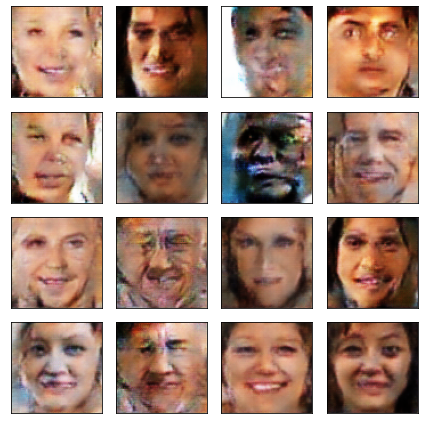




100%|██████████| 100/100 [28:01<00:00, 16.81s/it]


In [ ]:
EPOCHS = 100

critic_loss_3 = []
generator_loss_3 = []
for epoch in tqdm(range(EPOCHS)):
  print('\nEpoch', epoch)
  
  
  for step, (images, labels) in enumerate(new_ds):
    c_loss, g_loss = cgan_train_step(images, labels)
    if step % 50 == 0:
      print('critic loss at step {}: {}'.format(step, c_loss))
      print('generator loss at step {}: {}'.format(step, g_loss))
      critic_loss_3.append(tf.squeeze(c_loss))
      generator_loss_3.append(tf.squeeze(g_loss))
    

  display.clear_output(wait=True)

  plt.figure(figsize=(6,6))

  seed_noise, seed_label = seed_tensors()
  predictions = gen_4([seed_noise, seed_label], training=False)
  for i in range(predictions.shape[0]):
    ax = plt.subplot(4, 4, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(tf.cast((predictions[i,:, :, :] * 127.0) + 127.5, tf.uint32))
    plt.tight_layout()
      
  
  plt.savefig('/content/drive/MyDrive/mnist_pngs/cgan_rgb_face_img_{epoch}'.format(epoch=epoch))
  plt.show()

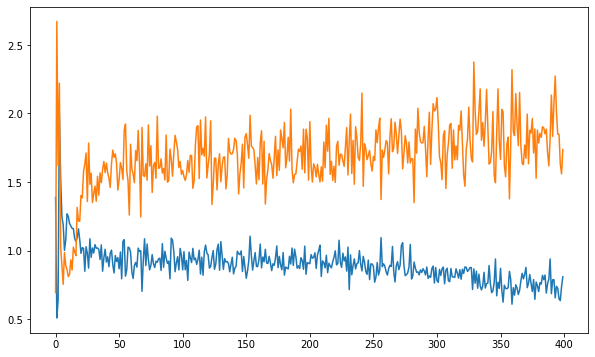

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(critic_loss_3)
plt.plot(generator_loss_3)

We see similar results to the simple DCGAN, however now we can input a desired label vector into our trained generator and see the results.

First we create a noise and label vectors

In [ ]:
noise = tf.random.normal([16,n_dim])

label_60_0_3 = tf.reshape(tf.tile(tf.constant([60, 0, 3], dtype=tf.int32), multiples=[16]),shape=(16,3))
label_40_1_2 = tf.reshape(tf.tile(tf.constant([40, 1, 2], dtype=tf.int32), multiples=[16]),shape=(16,3))
label_30_0_0 = tf.reshape(tf.tile(tf.constant([30, 0, 0], dtype=tf.int32), multiples=[16]),shape=(16,3))
label_3_1_1 = tf.reshape(tf.tile(tf.constant([3, 1, 1], dtype=tf.int32), multiples=[16]),shape=(16,3))

Then we feed these vectors to the generator and plot the generated images

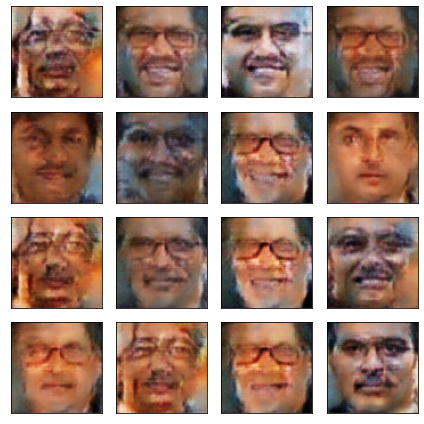

In [ ]:

p60 = gen_4([noise, label_60_0_3], training=False)
p40 = gen_4([noise, label_40_1_2], training=False)
p30 = gen_4([noise, label_30_0_0], training=False)
p3 = gen_4([noise, label_3_1_1], training=False)

plt.figure(figsize=(6,6))
for i in range(16):
  ax = plt.subplot(4, 4, i+1)
  ax.set_xticks([])
  ax.set_yticks([])
  plt.imshow(tf.cast((p60[i,:, :,:] * 127.0) + 127.5, tf.uint32))
  plt.tight_layout()

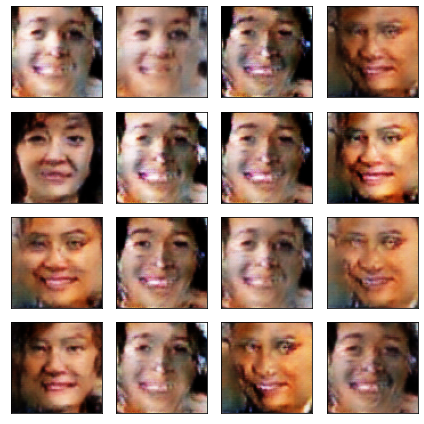

In [ ]:
plt.figure(figsize=(6,6))
for j in range(16):
  ax1 = plt.subplot(4, 4, j+1)
  ax1.set_xticks([])
  ax1.set_yticks([])
  plt.imshow(tf.cast((p40[j,:, :,:] * 127.0) + 127.5, tf.uint32))
  plt.tight_layout()

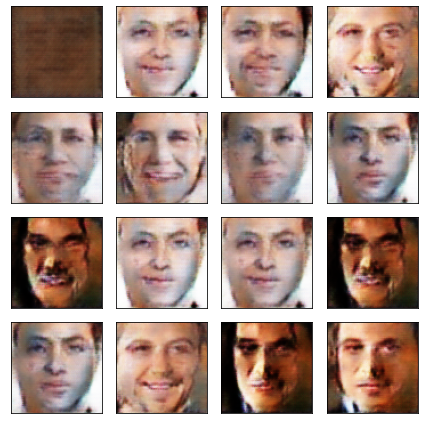

In [ ]:
plt.figure(figsize=(6,6))
for j in range(16):
  ax1 = plt.subplot(4, 4, j+1)
  ax1.set_xticks([])
  ax1.set_yticks([])
  plt.imshow(tf.cast((p30[j,:, :,:] * 127.0) + 127.5, tf.uint32))
  plt.tight_layout()

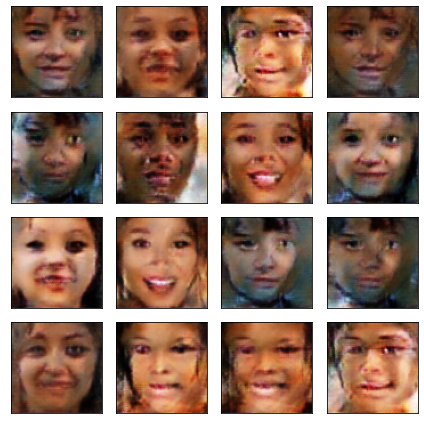

In [ ]:
plt.figure(figsize=(6,6))
for j in range(16):
  ax1 = plt.subplot(4, 4, j+1)
  ax1.set_xticks([])
  ax1.set_yticks([])
  plt.imshow(tf.cast((p3[j,:, :,:] * 127.0) + 127.5, tf.uint32))
  plt.tight_layout()

We see that different labels produce different results in terms of diversity and image quality. This is probably because certain categories have more examples and therefore the generator has learned a better representation of them in terms of random noise vectors. However we have demonstrated that with a few simple modifications we produce images depending on a certain condition imposed on the generator.